Parachute Surface Area (input): 10.00 ft^2
Drone Weight (input): 2.00 lbs
Nominal Diameter: 1.78 ft
Sea Level Descent Rate: 11.37 ft/s
Max Speed: 33.76 ft/s
Max Absolute Acceleration: 35.55 ft/s²
Final Speed At Impact: 11.38 ft/s
Impact Energy: 5.46 J


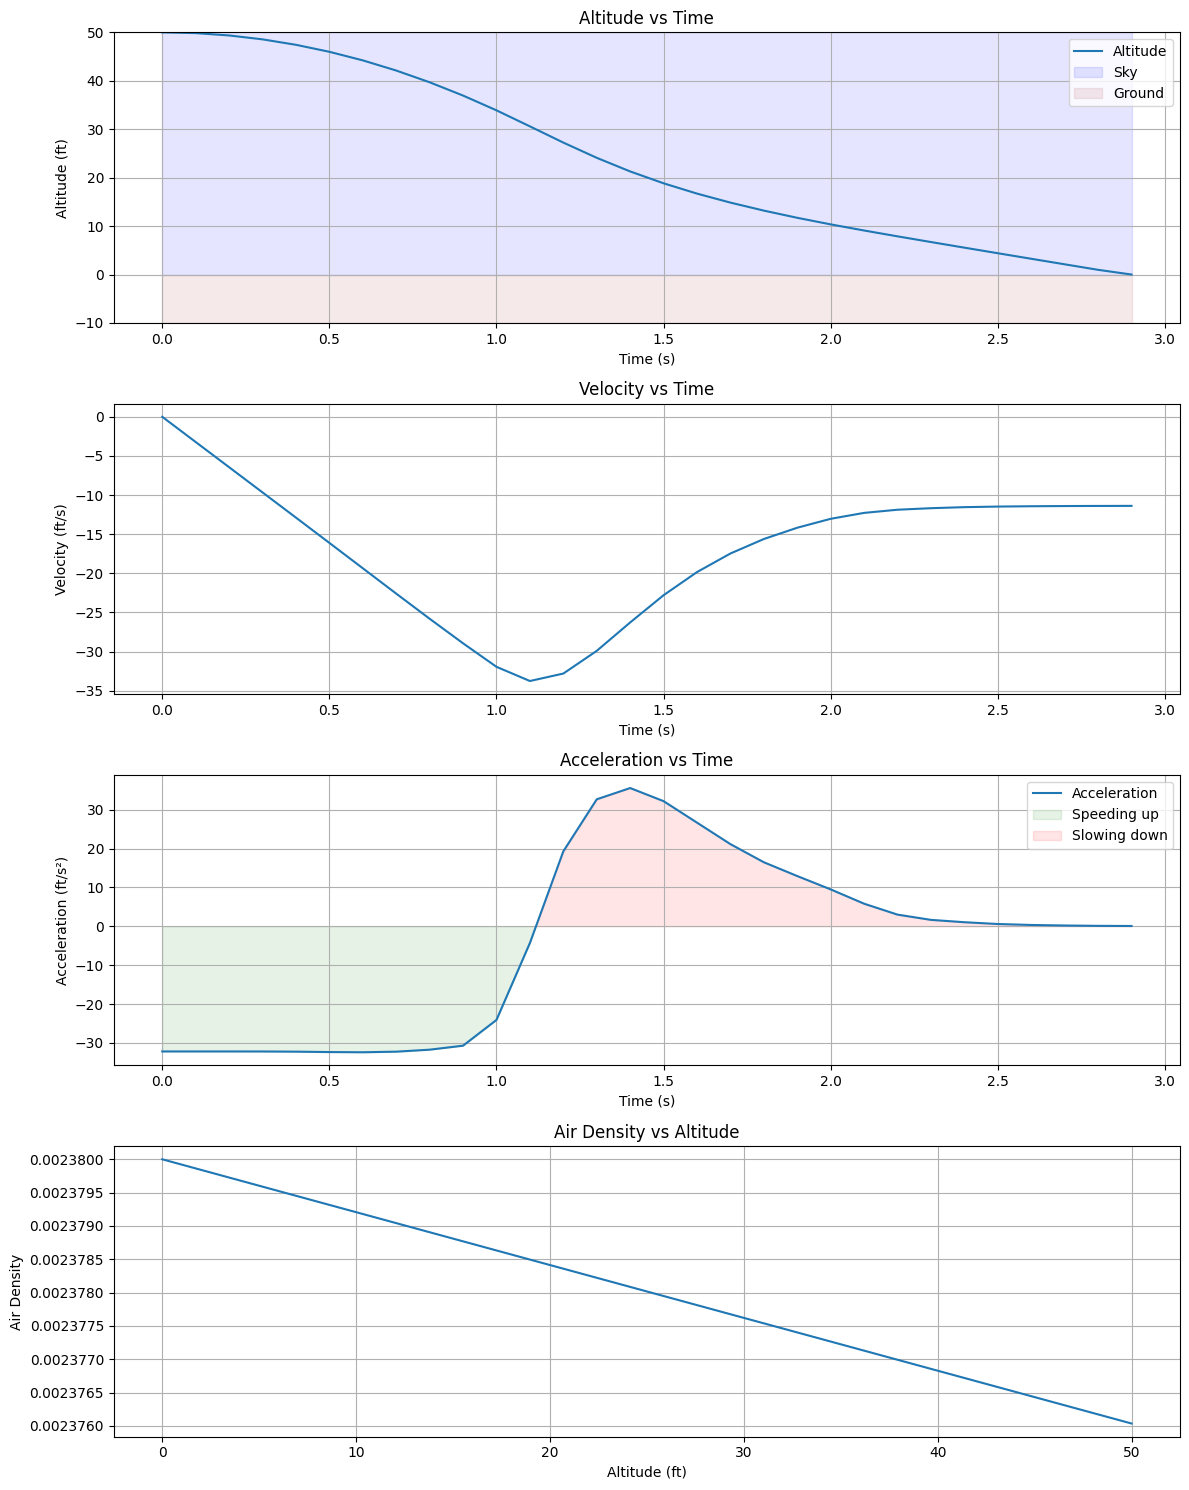

0.1
Progress: 0.01%
Progress: 0.02%
Progress: 0.03%
Progress: 0.04%
Progress: 0.05%
Progress: 0.06%
Progress: 0.07%
Progress: 0.08%
Progress: 0.09%
Progress: 0.10%
Progress: 0.11%
Progress: 0.12%
Progress: 0.13%
Progress: 0.14%
Progress: 0.15%
Progress: 0.16%
Progress: 0.17%
Progress: 0.18%
Progress: 0.19%
Progress: 0.20%
Progress: 0.21%
Progress: 0.22%
Progress: 0.23%
Progress: 0.24%
Progress: 0.25%
Progress: 0.26%
Progress: 0.27%
Progress: 0.28%
Progress: 0.29%
Progress: 0.30%
Progress: 0.31%
Progress: 0.32%
Progress: 0.33%
Progress: 0.34%
Progress: 0.35%
Progress: 0.36%
Progress: 0.37%
Progress: 0.38%
Progress: 0.39%
Progress: 0.40%
Progress: 0.41%
Progress: 0.42%
Progress: 0.43%
Progress: 0.44%
Progress: 0.45%
Progress: 0.46%
Progress: 0.47%
Progress: 0.48%
Progress: 0.49%
Progress: 0.50%
Progress: 0.51%
Progress: 0.52%
Progress: 0.53%
Progress: 0.54%
Progress: 0.55%
Progress: 0.56%
Progress: 0.57%
Progress: 0.58%
Progress: 0.59%
Progress: 0.60%
Progress: 0.61%
Progress: 0.62%
Prog

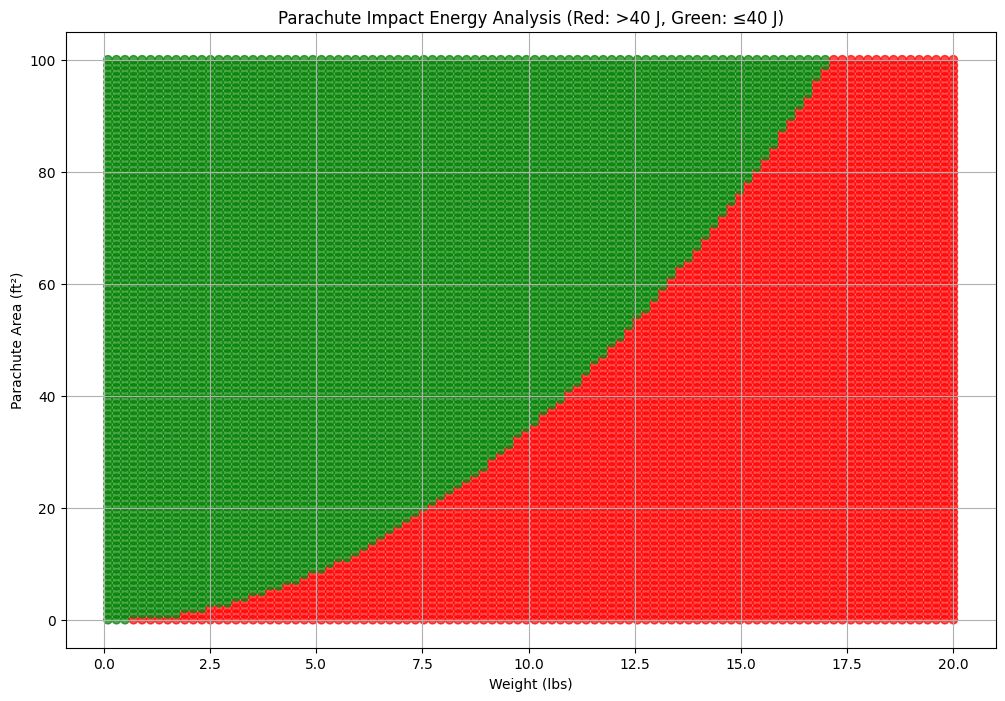

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Callable
from scipy.integrate import solve_ivp

@dataclass
class ParachuteParameters:
    """Class to hold parachute design parameters"""
    So: float  # Total canopy surface area (ft² or m²)
    Wt: float  # Total weight (lbs or N)
    Cdo: float  # Drag coefficient
    n: float   # Dimensionless fill constant

class ParachuteCalculator:
    """Class to perform parachute design calculations"""
    
    def __init__(self, params: ParachuteParameters):
        self.params = params
        # Standard sea level air density (slugs/ft³ or kg/m³)
        self.rho_sea_level = 0.00238  # slugs/ft³ (1.225 kg/m³) - at sea level and at 58°F (15°C)
        self.g = 32.2  # ft/s² (9.81 m/s²)
        
    def calculate_nominal_diameter(self) -> float:
        return np.sqrt((self.params.So / np.pi))
    
    def calculate_descent_rate_sea_level(self) -> float:
        return np.sqrt((2 * self.params.Wt) / 
                     (self.params.So * self.params.Cdo * self.rho_sea_level))
    
    def calculate_descent_rate_altitude(self, rho_altitude: float) -> float:
        vco = self.calculate_descent_rate_sea_level()
        return vco * np.sqrt(self.rho_sea_level / rho_altitude)
    
    def calculate_filling_distance(self, Dp: float) -> float:
        return self.params.n * Dp
    
    def simulate_descent(self, initial_altitude: float, 
                         free_fall_time: float = 0, 
                         fill_time: float = 1.0,  # Time for parachute to fully deploy
                         dt: float = 0.1, 
                         rho_altitude_func: Callable[[float], float] = None) -> Tuple[np.ndarray, ...]:
        """
        Simulate complete descent using `solve_ivp`.
        """
        if rho_altitude_func is None:
            rho_altitude_func = lambda h: self.rho_sea_level * np.exp(-h / 30000)
        
        def odes(t, y):
            h, v = y  # Unpack altitude and velocity
            if h <= 0:
                return [0, 0]  # Stop simulation when altitude is 0 or below
            
            rho = rho_altitude_func(h)
            Fg = self.params.Wt  # Gravitational force
            
            # Compute drag coefficient during parachute fill time
            if t < free_fall_time:
                Cdo_eff = 0  # No drag before parachute starts opening
            elif free_fall_time <= t < free_fall_time + fill_time:
                # Linearly increase drag coefficient during fill time
                Cdo_eff = self.params.Cdo * ((t - free_fall_time) / fill_time)
            else:
                Cdo_eff = self.params.Cdo  # Fully deployed after fill time
            
            # Calculate drag force
            Fd = 0.5 * rho * v**2 * Cdo_eff * self.params.So
            Fnet = Fg - Fd
            a = Fnet / (self.params.Wt / self.g)
            return [v, -a]
        
        y0 = [initial_altitude, 0]  # Initial altitude and velocity
        t_span = (0, 1000)  # Simulate for a max of 1000 seconds
        t_eval = np.arange(0, 1000, dt)  # Time intervals for evaluation
        
        solution = solve_ivp(odes, t_span, y0, t_eval=t_eval, method='RK45')
        
        time_points = solution.t
        altitudes = solution.y[0]
        velocities = solution.y[1]
        
        # Stop at ground
        ground_index = np.where(altitudes <= 0)[0]
        if len(ground_index) > 0:
            stop_index = ground_index[0]
            time_points = time_points[:stop_index + 1]
            altitudes = altitudes[:stop_index + 1]
            velocities = velocities[:stop_index + 1]
        
        accelerations = np.gradient(velocities, time_points)  # Approximate acceleration
        rho_values = [rho_altitude_func(h) for h in altitudes]
        
        return time_points, altitudes, velocities, accelerations, rho_values
    
    def plot_descent_simulation(self, Wt: float, initial_altitude: float, 
                                            free_fall_time: float = 0, 
                                            dt: float = 0.1,
                                            fill_time: float = 1.0,
                                            rho_altitude_func: Callable[[float], float] = None) -> None:
        times, altitudes, velocities, accelerations, rho_values = self.simulate_descent(
            initial_altitude, free_fall_time, fill_time, dt, rho_altitude_func)
        
        print(f"Max Speed: {max(abs(velocities)):.2f} ft/s")
        print(f"Max Absolute Acceleration: {max(abs(accelerations)):.2f} ft/s²")
        print(f"Final Speed At Impact: {abs(velocities[-1]):.2f} ft/s")

        FT_TO_M = 0.3048
        LB_TO_KG = 0.453592
        vco_mps = abs(velocities[-1]) * FT_TO_M
        mass_kg = Wt * LB_TO_KG
        impact_energy_joules = 0.5 * mass_kg * vco_mps**2
        print(f"Impact Energy: {impact_energy_joules:.2f} J")

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 15))

        # Altitude plot with sky and ground background
        ax1.plot(times, altitudes, label='Altitude')
        ax1.fill_between(times, 0, max(altitudes), color='blue', alpha=0.1, label='Sky')
        ax1.fill_between(times, -10, 0, color='brown', alpha=0.1, label='Ground')
        ax1.set_ylim(-10, max(altitudes))  # Set y-axis to start at -10
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Altitude (ft)')
        ax1.set_title('Altitude vs Time')
        ax1.legend()
        ax1.grid(True)

        # Velocity plot
        ax2.plot(times, velocities, label='Velocity')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Velocity (ft/s)')
        ax2.set_title('Velocity vs Time')
        ax2.grid(True)

        # Acceleration plot with background color based on speeding up or slowing down
        ax3.plot(times, accelerations, label='Acceleration')
        ax3.fill_between(times, accelerations, 0, where=(accelerations < 0), color='green', alpha=0.1, interpolate=True, label='Speeding up')
        ax3.fill_between(times, accelerations, 0, where=(accelerations > 0), color='red', alpha=0.1, interpolate=True, label='Slowing down')
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Acceleration (ft/s²)')
        ax3.set_title('Acceleration vs Time')
        ax3.legend()
        ax3.grid(True)

        # Air density vs altitude plot
        ax4.plot(altitudes, rho_values, label='Air Density')
        ax4.set_xlabel('Altitude (ft)')
        ax4.set_ylabel('Air Density')
        ax4.set_title('Air Density vs Altitude')
        ax4.grid(True)

        plt.tight_layout()
        plt.show()


# Example usage
def example_calculation():
    # Example parameters (using imperial units)
    params = ParachuteParameters(
        So=10,    # ft²
        Wt=2,    # lbs (Matrice 3000 with single gimbal and 2 batteries is 6.47 kg)
        Cdo=1.3,   # typical value for round parachutes
        n=3        # typical value for round parachutes
    )
    
    calculator = ParachuteCalculator(params)
    

    # Calculate parameters
    Do = calculator.calculate_nominal_diameter()
    vco = calculator.calculate_descent_rate_sea_level()  # descent rate in ft/s


    # Calculate impact energy in joules
    # impact_energy_joules = 0.5 * mass_kg * vco_mps**2

    # Print results
    print(f"Parachute Surface Area (input): {params.So:.2f} ft^2")
    print(f"Drone Weight (input): {params.Wt:.2f} lbs")
    print(f"Nominal Diameter: {Do:.2f} ft")
    print(f"Sea Level Descent Rate: {vco:.2f} ft/s")

    # Run and plot complete descent simulation
    calculator.plot_descent_simulation(Wt=params.Wt, initial_altitude=50, free_fall_time=1, dt=0.1, fill_time=1)  # 5000 ft initial altitude



    weight_range = np.linspace(0.1, 20, 100)  # Range of weights (lbs)
    area_range = np.linspace(0.1, 100, 100)    # Range of parachute areas (ft²)
    free_fall_time = 1
    fill_time = 1
    # Re-run the simulation for the full descent and impact energy
    initial_altitude = 400  # Set an initial altitude for all simulations (e.g., 2000 ft)
    dt = 0.1  # Time step for the simulation

    impact_energies = []
    colors = []
    weights = []
    areas = []

    total_iterations = len(weight_range) * len(area_range)  # Total number of iterations
    current_iteration = 0

    for weight in weight_range:
        print(weight)
        for area in area_range:
            # print(area)
            params = ParachuteParameters(
                So=area,    # ft²
                Wt=weight,  # lbs
                Cdo=1.3,    # typical value for round parachutes
                n=3         # typical value for round parachutes
            )
            calculator = ParachuteCalculator(params)
            
            # Run the full descent simulation
            _, _, velocities, _, _= calculator.simulate_descent(initial_altitude, free_fall_time, dt, fill_time)
            
            # Get the final velocity (last element of the velocity array)
            final_velocity = abs(velocities[-1])  # Ensure positive magnitude
            
            FT_TO_M = 0.3048  # feet to meters
            LB_TO_KG = 0.453592  # pounds to kilograms
            # Calculate the impact energy
            mass_kg = weight * LB_TO_KG  # Convert weight to mass
            final_velocity_mps = final_velocity * FT_TO_M  # Convert ft/s to m/s
            impact_energy_joules = 0.5 * mass_kg * final_velocity_mps**2
            # print("Final velocity")
            # print(final_velocity)
            # print("Impact energy")
            # print(impact_energy_joules)
            # Store results
            weights.append(weight)
            areas.append(area)
            impact_energies.append(impact_energy_joules)
            colors.append('red' if impact_energy_joules > 40 else 'green')

            current_iteration += 1
            # Calculate percentage complete
            percent_complete = (current_iteration / total_iterations) * 100
            # Print percentage complete
            print(f"Progress: {percent_complete:.2f}%")

    # Create scatter plot
    plt.figure(figsize=(12, 8))
    plt.scatter(weights, areas, c=colors, alpha=0.7, marker='o')  # Use dots
    plt.xlabel('Weight (lbs)')
    plt.ylabel('Parachute Area (ft²)')
    plt.title('Parachute Impact Energy Analysis (Red: >40 J, Green: ≤40 J)')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    example_calculation()